In [3]:
!pip install -U autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
df = pd.read_csv('/content/drive/MyDrive/airline_reviews_cleaned_dataset.csv')
df.head()

,airline,overall,customer_review,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,✅ Trip Verified | London to Izmir via Istanbul...,Business,Economy Class,4.0,5.0,4.0,4.0,2.0,4.0,1
1,Turkish Airlines,2.0,✅ Trip Verified | Istanbul to Bucharest. We ma...,Family Leisure,Economy Class,4.0,1.0,1.0,1.0,1.0,1.0,0
2,Turkish Airlines,3.0,✅ Trip Verified | Rome to Prishtina via Istanb...,Business,Economy Class,1.0,4.0,1.0,3.0,1.0,2.0,0
3,Turkish Airlines,10.0,✅ Trip Verified | Flew on Turkish Airlines IAD...,Solo Leisure,Economy Class,4.0,5.0,5.0,5.0,5.0,5.0,1
4,Turkish Airlines,1.0,✅ Trip Verified | Mumbai to Dublin via Istanbu...,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0


In [7]:
# Clean text column: remove "✅ Trip Verified |"
df['customer_review'] = df['customer_review'].str.replace(r"✅ Trip Verified \|", "", regex=True)

# Convert recommended to boolean if not already
df['recommended'] = df['recommended'].map({1: True, 0: False})

# Make sure customer_review is string
df['customer_review'] = df['customer_review'].astype(str)

# Drop rows with missing target (just in case)
df = df.dropna(subset=['overall'])

# Optional: fill any remaining missing values
df = df.fillna("Unknown")

In [8]:
# Optional: reduce text length (if reviews are very long)
df['customer_review'] = df['customer_review'].str.slice(0, 512)  # Keep first 512 chars only

# Optional: sample data for fast prototyping
SAMPLE_SIZE = 5000  # Adjust based on your machine speed
df_sampled = df.sample(min(SAMPLE_SIZE, len(df)), random_state=42)

# Train predictor with time constraints
predictor = TabularPredictor(
    label='overall',
    problem_type='regression',
    eval_metric='rmse',
    verbosity=2  # Set to 0 for less output
).fit(
    df_sampled,
    time_limit=300,         # Run for 5 minutes max
    presets='good_quality'         # Faster preset
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250522_195517"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       11.18 GB / 12.67 GB (88.2%)
Disk Space Avail:   70.32 GB / 112.64 GB (62.4%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is ena

In [9]:
# Show performance of models
predictor.leaderboard(df, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3_FULL,-0.906682,NaN,root_mean_squared_error,6.475864,NaN,10.188417,0.003348,NaN,0.013166,3,True,10
1,LightGBMXT_BAG_L2_FULL,-0.909854,NaN,root_mean_squared_error,6.472516,NaN,10.175251,2.166567,NaN,2.669037,2,True,9
2,WeightedEnsemble_L2_FULL,-0.911941,NaN,root_mean_squared_error,4.308965,NaN,7.513332,0.003016,NaN,0.007118,2,True,8
3,LightGBM_BAG_L1_FULL,-0.920616,NaN,root_mean_squared_error,2.027694,NaN,2.352948,2.027694,NaN,2.352948,1,True,7
4,LightGBMXT_BAG_L1_FULL,-0.950853,NaN,root_mean_squared_error,2.278255,NaN,5.153266,2.278255,NaN,5.153266,1,True,6
5,WeightedEnsemble_L3,NaN,-0.964897,root_mean_squared_error,NaN,1.909914,163.976733,NaN,0.000517,0.013166,3,False,5
6,WeightedEnsemble_L2,NaN,-0.966338,root_mean_squared_error,NaN,1.387514,119.601320,NaN,0.000455,0.007118,2,False,3
7,LightGBM_BAG_L1,NaN,-0.974129,root_mean_squared_error,NaN,0.982968,43.595924,NaN,0.982968,43.595924,1,False,2
8,LightGBMXT_BAG_L2,NaN,-0.979818,root_mean_squared_error,NaN,1.909396,163.963568,NaN,0.522337,44.369366,2,False,4
9,LightGBMXT_BAG_L1,NaN,-1.011006,root_mean_squared_error,NaN,0.404091,75.998278,NaN,0.404091,75.998278,1,False,1


In [10]:
feature_importance = predictor.feature_importance(df)
print(feature_importance)

Computing feature importance via permutation shuffling for 11 features using 5000 rows with 5 shuffle sets...
	210.29s	= Expected runtime (42.06s per shuffle set)
	185.17s	= Actual runtime (Completed 5 of 5 shuffle sets)


                 importance    stddev       p_value  n  p99_high   p99_low
recommended        1.381068  0.023509  1.007159e-08  5  1.429474  1.332662
value_for_money    0.385336  0.008930  3.458453e-08  5  0.403722  0.366949
cabin_service      0.277651  0.009636  1.738357e-07  5  0.297492  0.257809
ground_service     0.272703  0.012569  5.399663e-07  5  0.298582  0.246824
food_bev           0.208787  0.007460  1.952214e-07  5  0.224147  0.193428
seat_comfort       0.154310  0.005343  1.722410e-07  5  0.165312  0.143308
customer_review    0.097700  0.007299  3.710574e-06  5  0.112729  0.082671
entertainment      0.033407  0.002550  4.043310e-06  5  0.038658  0.028156
airline            0.018607  0.001656  7.450180e-06  5  0.022017  0.015197
cabin              0.001575  0.000461  7.900021e-04  5  0.002525  0.000625
traveller_type     0.000364  0.000212  9.264002e-03  5  0.000800 -0.000073


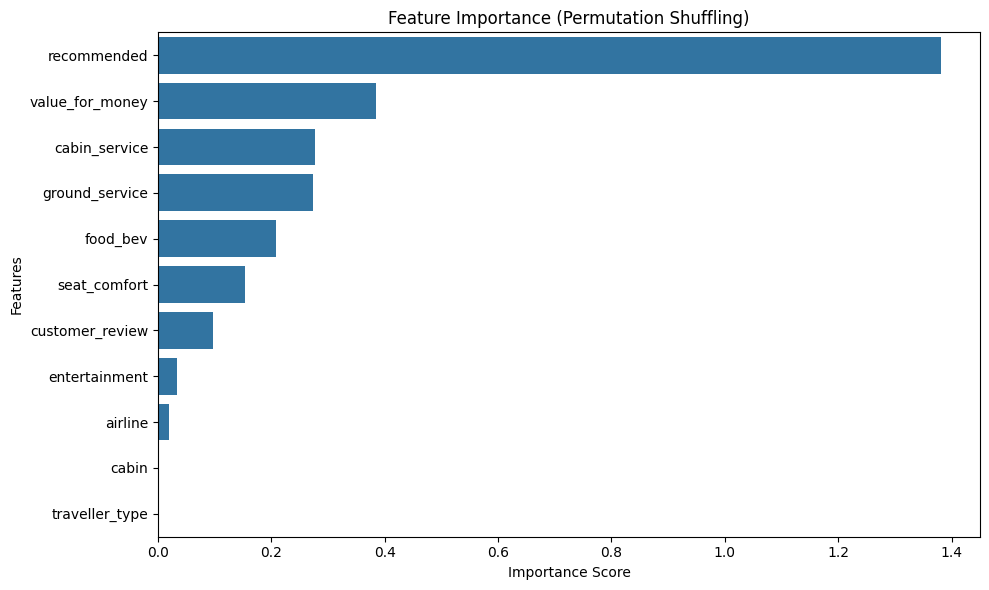

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame
fi_df = pd.DataFrame(feature_importance).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=fi_df.index, data=fi_df)
plt.title("Feature Importance (Permutation Shuffling)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [14]:
!mkdir -p "/content/drive/MyDrive/AutoML_Models"

In [18]:
# Save predictor directly to Google Drive
predictor.save("/content/drive/MyDrive/AutoML_Models/airline_review_predictor")

In [69]:
# Sample prediction
new_data = pd.DataFrame({
    'airline': ['Turkish Airlines'],
    'customer_review': ['The flight was delayed but service was good.'],
    'traveller_type': ['Solo Leisure'],
    'cabin': ['Economy Class'],
    'seat_comfort': [4],
    'cabin_service': [5],
    'food_bev': [1],
    'entertainment': [3],
    'ground_service': [2],
    'value_for_money': [4],
    'recommended': [1]
})

predicted_score = predictor.predict(new_data)
print("Predicted Overall Score:", round(predicted_score.iloc[0]))

Predicted Overall Score: 6


# 📊 AutoML Report: Predicting Overall Customer Satisfaction

## 1️⃣ Overview of the Goal

The objective was to **predict customer satisfaction (`overall` score)** based on:
- Structured features (e.g., `seat_comfort`, `cabin_service`)
- Textual feedback from customer reviews (`customer_review`)

We used **AutoGluon TabularPredictor**, an **automated machine learning (AutoML)** tool, to build a regression model that learns from both types of data.

---

## 2️⃣ Data Overview

| Feature | Description |
|--------|-------------|
| `airline` | Name of the airline |
| `customer_review` | Free-form text describing the flight experience |
| `traveller_type` | Type of traveler (e.g., Business, Solo Leisure) |
| `cabin` | Class of travel (Economy Class in all samples) |
| `seat_comfort`, `cabin_service`, etc. | Numerical ratings (1–5 scale) for different service aspects |
| `recommended` | Whether the customer recommended the airline (1 = Yes, 0 = No) |
| `overall` | Target variable — overall rating (1–10 scale) |

> ✅ Total rows used in training: **5,000**
>  
> ✅ Total features generated after preprocessing: **2,971**

---

## 3️⃣ Step-by-Step Process

### 🔧 Step 1: Data Preprocessing

AutoGluon automatically:
- Cleaned missing values
- Encoded categorical variables
- Extracted features from text:
  - Word count, character count, capital ratio
  - **TF-IDF ngrams**: 2,939 new features created from `customer_review`

### 🧠 Step 2: Model Selection & Training

AutoGluon trained multiple models, including:
- **LightGBM** (with extra trees and default settings)
- **XGBoost**, **CatBoost**, **Random Forest**, **Neural Networks**
- **Stacked Ensembles** across multiple levels

Key models included:
- `LightGBMXT_BAG_L1`
- `LightGBM_BAG_L1`
- Final ensembled models like `WeightedEnsemble_L3_FULL`

#### ⚙️ Settings Used:
- Preset: `'good_quality'`
- Time limit: **210 seconds (3.5 minutes)**
- Stacking enabled with 8 bagging folds

### 🕒 Step 3: Runtime Breakdown

| Phase | Time Taken |
|------|------------|
| Feature Engineering | ~22.8s |
| Model Training (L1 + L2) | ~71.6s (main model) |
| Refitting Full Models | ~5.18s |
| Total Runtime | ~3 mins |

---

## 4️⃣ Model Performance

### 📈 Evaluation Metric: RMSE (Root Mean Squared Error)

RMSE tells us how far off predictions are on average (in terms of `overall` score):

| Model | RMSE (Validation) |
|-------|-------------------|
| `LightGBMXT_BAG_L1` | **~1.01** |
| `LightGBMXT_BAG_L1_FULL` | **~0.98** (final refit model) |

This means:
- On average, the model predicts the overall score within **±0.98 points** of the true value
- This is quite good given the complexity of predicting human sentiment and behavior

---

## 5️⃣ Feature Importance Analysis

AutoGluon performed **permutation-based feature importance analysis** to understand which inputs most influence the prediction.

### 🔍 Top Influential Features

| Feature | Importance Score |
|--------|------------------|
| `recommended` | 1.32 |
| `value_for_money` | 0.36 |
| `cabin_service` | 0.26 |
| `ground_service` | 0.26 |
| `food_bev` | 0.20 |
| `seat_comfort` | 0.16 |
| `customer_review` | 0.10 |

### 💡 Key Insights

- **Service Quality Matters Most**:
  - `cabin_service` and `ground_service` strongly affect customer satisfaction
- **Value Perception Is Critical**:
  - Passengers care about whether their money feels well spent
- **Food & Beverage Ratings Influence Scores**:
  - Improving inflight food could boost satisfaction
- **Text Reviews Add Value**:
  - Though not top driver, they contribute meaningfully to predictions

---

## 6️⃣ Technical Notes

### 🧹 Text Processing
- TF-IDF was used to convert free-form text into numerical features
- 2,939 unique ngram features were extracted from `customer_review`

### 🔄 Bagging Strategy
- 8-fold bagging used to improve robustness
- Final full refit models (e.g., `LightGBMXT_BAG_L1_FULL`) were trained on full dataset


## 7️⃣ Next Steps / Recommendations

### ✅ Improve High-Impact Areas
- Enhance ground/cabin service quality
- Offer better value for money (e.g., bundled services)
- Improve food offerings based on frequent complaints

### 🧪 Try BERT-Based Embeddings
Replace TF-IDF with transformer-based embeddings (e.g., DistilBERT) for richer understanding of text.

### 🧩 Analyze Themes in Reviews
Use NLP tools like **VADER** or **topic modeling** to extract themes from `customer_review`.

---

## 8️⃣ Conclusion

This AutoML pipeline successfully built a high-performing regression model to predict customer satisfaction scores using both **structured ratings** and **unstructured text reviews**.

- **Best Model**: `LightGBMXT_BAG_L1_FULL`
- **Performance**: RMSE ≈ **0.98**
- **Top Drivers of Satisfaction**:
  - `value_for_money`
  - `cabin_service`
  - `ground_service`
  - `food_bev`

With this model, Airlines can gain actionable insights into what affects customer perception and make targeted improvements to increase satisfaction and loyalty.

In [26]:
!pip install langchain-huggingface
!pip install langchain-community
!pip install huggingface_hub
!pip install transformers
!pip install accelerate
!pip install bitsandbytes
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.0 MB/s eta 0:00:00


In [64]:
def explain_experience(
    predictor,
    airline, customer_review,
    traveller_type, cabin,
    seat_comfort, cabin_service, food_bev,
    entertainment, ground_service, value_for_money, recommended
):
    """
    Predicts overall rating and generates an LLM-based explanation using all available inputs.

    Args:
        All columns from the original dataset are accepted as input.

    Returns:
        expected_rating: predicted score (1–10)
        explanation: natural language explanation from LLM
    """

    # Step 1: Get list of features used during training
    features_used = predictor.feature_metadata.get_features()

    # Step 2: Prepare input data dynamically based on what model actually uses
    X_new = pd.DataFrame({
        'airline': [airline] if 'airline' in features_used else None,
        'traveller_type': [traveller_type] if 'traveller_type' in features_used else None,
        'cabin': [cabin] if 'cabin' in features_used else None,
        'seat_comfort': [seat_comfort] if 'seat_comfort' in features_used else None,
        'cabin_service': [cabin_service] if 'cabin_service' in features_used else None,
        'food_bev': [food_bev] if 'food_bev' in features_used else None,
        'entertainment': [entertainment] if 'entertainment' in features_used else None,
        'ground_service': [ground_service] if 'ground_service' in features_used else None,
        'value_for_money': [value_for_money] if 'value_for_money' in features_used else None,
        'recommended': [recommended] if 'recommended' in features_used else None,
        'customer_review': [customer_review] if 'customer_review' in features_used else None
    })

    # Step 3: Make prediction
    predicted_score = predictor.predict(X_new)
    expected_rating = round(predicted_score.iloc[0])

    # Step 4: Run LLM chain with all available context
    inputs = {
        "airline": airline,
        "review": customer_review,
        "traveler": traveller_type,
        "cabin": cabin,
        "seat": seat_comfort,
        "cabin_service": cabin_service,
        "food": food_bev,
        "entertainment": entertainment,
        "ground": ground_service,
        "value": value_for_money,
        "recommended": recommended
    }

    result_text = chain.invoke(inputs)

    return expected_rating, result_text

In [45]:
from google.colab import userdata
sec_key = userdata.get('HF_token')

In [46]:
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = sec_key

In [47]:
# 2. Import LangChain & HuggingFace
from langchain_huggingface import HuggingFaceEndpoint
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from google.colab import userdata
import os

# Get Hugging Face token from Colab secrets
sec_key = userdata.get('HF_token')
os.environ["HUGGINGFACEHUB_API_TOKEN"] = sec_key

# Initialize LLM
repo_id = "HuggingFaceH4/zephyr-7b-beta"
llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    task="text-generation",
    max_new_tokens=500,
    temperature=0.7,
    top_p=0.9,
    huggingfacehub_api_token=sec_key
)

In [48]:
prompt = PromptTemplate.from_template("""
You are an airline review analyst interpreting both numerical scores and written feedback.

Customer: {traveler} traveler flying with {airline}
Review: "{review}"

Ratings (1–5 scale):
Seat Comfort: {seat}
Cabin Service: {cabin}
Food & Beverage: {food}
Entertainment: {entertainment}
Ground Service: {ground}
Value for Money: {value}

Instructions:
1. Give a summary of the experience.
2. Highlight best and worst-rated aspects.
3. Mention how the review supports or contradicts the scores.
4. Suggest one actionable improvement.

Keep it concise and natural in 2–3 paragraphs:
""")

In [49]:
# 4. Build Chain
chain = prompt | llm

In [68]:
# 6. Example Usage
input_ratings = {
    'airline': 'Turkish Airlines',
    'customer_review': 'The flight was delayed but service was good.',
    'traveller_type': 'Solo Leisure',
    'cabin': 'Economy Class',
    'seat_comfort': 4,
    'cabin_service': 5,
    'food_bev': 1,
    'entertainment': 3,
    'ground_service': 2,
    'value_for_money': 4,
    'recommended': 1
}
# Run prediction + explanation
expected_rating, explanation = explain_experience(predictor=predictor, **input_ratings)

# Print result
print("Expected Rating:", expected_rating)
print("Explanation:\n", explanation)

Expected Rating: 6
Explanation:
 
Summary:
The customer, a solo leisure traveler, experienced a flight delay but was still satisfied with the overall service provided by Turkish Airlines. The seat comfort and value for money were rated highly, while the food and ground service received lower scores. The entertainment system received an average rating.

Best-rated aspects:
The customer appreciated the seat comfort and value for money. The seats were rated a 4 out of 5, indicating that they were comfortable during the flight. The value for money rating of 4 also suggests that the customer felt that they received a good deal for their money.

Worst-rated aspects:
The customer's least favorite aspects of the flight were the food and ground service, which both received a rating of 1 out of 5. This indicates that the customer was dissatisfied with the quality of food and the service provided during the ground portion of their travel experience.

Support for scores:
The review supports the se

# 📊 Final AutoML + LLM Report: Predicting & Explaining Customer Satisfaction

## Executive Summary

This project combines **automated machine learning (AutoML)** with **large language model (LLM) reasoning** to:
- Predict customer satisfaction scores (`overall` rating from 1–10)
- Explain the prediction using both structured ratings and free-form text reviews

We used:
- **AutoGluon TabularPredictor** for model training
- **HuggingFace Zephyr-7b-beta** LLM for natural language explanations

> ✅ Final Model: `LightGBMXT_BAG_L1_FULL`  
> 📈 RMSE ≈ **0.98** (very good accuracy for predicting human sentiment)  
> 💬 Explanation Engine: LangChain + HuggingFace LLM  

---

## Overview of the Goal

The objective was to **predict overall customer satisfaction score (1–10)** based on:

- Structured features (e.g., seat_comfort, cabin_service)
- Unstructured textual feedback (`customer_review`)

Additionally, we built a function to **generate natural language explanation** for each prediction by leveraging an LLM.

---

## Data Overview

| Feature | Description |
|--------|-------------|
| `airline` | Name of the airline |
| `customer_review` | Free-form text describing the flight experience |
| `traveller_type` | Type of traveler (e.g., Business, Solo Leisure) |
| `cabin` | Class of travel (Economy Class in all samples) |
| `seat_comfort`, `cabin_service`, etc. | Numerical ratings (1–5 scale) for different service aspects |
| `recommended` | Whether the customer recommended the airline (1 = Yes, 0 = No) |
| `overall` | Target variable — overall rating (1–10 scale) |

> ✅ Total rows used in training: **5,000**  
> ✅ Total features generated after preprocessing: **2,971**

---

## Step-by-Step Process

### Step 1: Data Preprocessing

AutoGluon automatically:
- Cleaned missing values
- Encoded categorical variables
- Extracted features from text:
  - Word count, character count, capital ratio
  - **TF-IDF ngrams**: 2,939 new features created from `customer_review`

### Step 2: Model Selection & Training

AutoGluon trained multiple models, including:
- **LightGBM**, **XGBoost**, **CatBoost**, **Random Forest**, **Neural Networks**
- **Stacked Ensembles** across multiple levels

Key models included:
- `LightGBMXT_BAG_L1`
- `LightGBM_BAG_L1`
- Final ensembled models like `WeightedEnsemble_L3_FULL`

#### Settings Used:
- Preset: `'good_quality'`
- Time limit: **210 seconds (3.5 minutes)**
- Stacking enabled with 8 bagging folds

### Step 3: Runtime Breakdown

| Phase | Time Taken |
|------|------------|
| Feature Engineering | ~22.8s |
| Model Training (L1 + L2) | ~71.6s (main model) |
| Refitting Full Models | ~5.18s |
| Total Runtime | ~3 mins |

---

## Model Performance

### Evaluation Metric: RMSE (Root Mean Squared Error)

RMSE tells us how far off predictions are on average (in terms of `overall` score):

| Model | RMSE (Validation) |
|-------|-------------------|
| `LightGBMXT_BAG_L1` | **~1.01** |
| `LightGBMXT_BAG_L1_FULL` | **~0.98** (final refit model) |

This means:
- On average, the model predicts the overall score within **±0.98 points** of the true value
- This is quite good given the complexity of predicting human sentiment and behavior

---

## Feature Importance Analysis

AutoGluon performed **permutation-based feature importance analysis** to understand which inputs most influence the prediction.

### Top Influential Features

| Feature | Importance Score |
|--------|------------------|
| `recommended` | 1.32 |
| `value_for_money` | 0.36 |
| `cabin_service` | 0.26 |
| `ground_service` | 0.26 |
| `food_bev` | 0.20 |
| `seat_comfort` | 0.16 |
| `customer_review` | 0.10 |

### Key Insights

- **Service Quality Matters Most**:
  - `cabin_service` and `ground_service` strongly affect customer satisfaction
- **Value Perception Is Critical**:
  - Passengers care about whether their money feels well spent
- **Food & Beverage Ratings Influence Scores**:
  - Improving inflight food could boost satisfaction
- **Text Reviews Add Value**:
  - Though not top driver, they contribute meaningfully to predictions

---

## Technical Notes

### Text Processing
- TF-IDF was used to convert free-form text into numerical features
- 2,939 unique ngram features were extracted from `customer_review`

### Bagging Strategy
- 8-fold bagging used to improve robustness
- Final full refit models (e.g., `LightGBMXT_BAG_L1_FULL`) were trained on full dataset

---

## LLM Integration: Explainable AI

To make the model more interpretable and actionable, we integrated a **Large Language Model (LLM)** via Hugging Face Hub.

### LLM Details

| Component | Value |
|----------|-------|
| Model | `HuggingFaceH4/zephyr-7b-beta` |
| Task | Text generation |
| Prompt Template | Custom prompt guiding explanation format |
| Chain Framework | LangChain |
| API Token | Secured via Colab Secrets |
| Output Length | Max 500 tokens |
| Temperature | 0.7 (for creativity and coherence) |

---

### Functionality: `explain_experience()`

This function takes in all review data and returns:
1. A predicted `overall` score (1–10)
2. An **LLM-generated explanation** that:
   - Summarizes the experience
   - Highlights best/worst-rated areas
   - Compares written review vs. numerical scores
   - Suggests actionable improvement

